# Fruit Rottenness Detection Using CNN

## Import Statements

In [1]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import Sequence


## Setting the path to dataset

In [2]:
# Set the path to your dataset
train_data_dir = 'dataset2/training_set'
test_data_dir = 'dataset2/test_set'
img_width, img_height = 35, 35
batch_size = 50
epochs = 15


## Defining functions for Preprocessing Image

### Segmentation (K-Means Clustering)

In [3]:
def custom_preprocessing(image):
    pixels = image.reshape((-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 3
    pixels = np.float32(pixels)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image.astype('float32')


### Grayscale

In [4]:
# Creating Grayscale Version of the Image
def custom_preprocessing2(image):
    # Convert the RGB image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Expand dimensions to make it compatible with the model's input shape
    grayscale_image = np.expand_dims(grayscale_image, axis=-1)
    
    return grayscale_image.astype('float32')

### Edge Detection

In [5]:

#Applying Edge Detection
def custom_preprocessing3(image):
    # Convert the RGB image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Ensure that the image is of type np.uint8
    grayscale_image = grayscale_image.astype(np.uint8)
    
    # Apply Canny edge detection
    edges = cv2.Canny(grayscale_image, 50, 150)
    
    # Expand dimensions to make it compatible with the model's input shape
    edges = np.expand_dims(edges, axis=-1)
    
    return edges.astype('float32')


### Noise Addition

In [6]:
#Applying Noise
def custom_preprocessing4(image):
    noise_intensity=25
    # Generate Gaussian noise
    noise = np.random.normal(0, noise_intensity, image.shape)

    # Add noise to the original image
    noisy_image = np.clip(image + noise, 0, 255).astype('uint8')

    return noisy_image.astype('float32')


### Shading

In [7]:
#Applying Shading
def custom_preprocessing5(image):
    gamma=3
    shaded_image = np.clip(np.power(image / 255.0, gamma) * 255.0, 0, 255).astype('uint8')
    
    return shaded_image.astype('float32')


## Data Preprocessing

### Creating different generators representing each of the preprocessing function

In [8]:

# Data Preprocessing
train_datagen1 = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=custom_preprocessing
)

# DirectoryIterator for the dataset
train_generator1 = train_datagen1.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 19317 images belonging to 8 classes.


In [9]:

train_datagen2 = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=custom_preprocessing2
)

train_generator2 = train_datagen2.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 19317 images belonging to 8 classes.


In [10]:

train_datagen3 = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,    
    preprocessing_function=custom_preprocessing3
)

train_generator3 = train_datagen3.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 19317 images belonging to 8 classes.


In [11]:
train_datagen4 = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,    
    preprocessing_function=custom_preprocessing4
)

train_generator4 = train_datagen4.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 19317 images belonging to 8 classes.


In [12]:
train_datagen5 = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,    
    preprocessing_function=custom_preprocessing5
)

train_generator5 = train_datagen5.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 19317 images belonging to 8 classes.


In [13]:
train_datagen6 = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator6 = train_datagen6.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 19317 images belonging to 8 classes.


### Creating the test generator

In [14]:
test_datagen = ImageDataGenerator(rescale = 1.0/255)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 6154 images belonging to 8 classes.


## Concatenation of all the Generators

### Creating the class for combining all the generators

In [15]:

class ConcatenateGenerators(Sequence):
    def __init__(self, generators):
        self.generators = generators
        self.lengths = [len(gen) for gen in generators]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, index):
        generator_index = np.argmax(index < self.cumulative_lengths)
        if generator_index > 0:
            sample_index = index - self.cumulative_lengths[generator_index - 1]
        else:
            sample_index = index

        # Get the data and labels from the corresponding generator
        data, labels = self.generators[generator_index][sample_index]
        return data, labels

### Combination of multiple generators into a single generator

In [16]:

combined_generator = ConcatenateGenerators([train_generator1, train_generator2, train_generator3, train_generator4, train_generator5, train_generator6])

## Building the CNN

### Defining the layers

In [17]:

# Initialising the CNN
model = tf.keras.models.Sequential()

# Step 1 - Convolution
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[35, 35, 3]))
# model.add(tf.keras.layers.BatchNormalization())

# Step 2 - Pooling
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# model.add(tf.keras.layers.BatchNormalization())

# Adding a second convolutional layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# model.add(tf.keras.layers.BatchNormalization())

# Step 3 - Flattening
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.BatchNormalization())

# Step 4 - Full Connection
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())

# Step 5 - Output Layer
model.add(tf.keras.layers.Dense(units=8, activation='softmax'))


### Compiling the model

In [18]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#                 initial_learning_rate = 1e-3,
#                 decay_steps = 10000,
#                 decay_rate = 0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


### Training the CNN model

In [19]:

history = model.fit(combined_generator, epochs=epochs, validation_data=test_generator)


Epoch 1/15


2322/2322 [==============================] - 397s 171ms/step - loss: 0.8719 - accuracy: 0.6730 - val_loss: 0.3305 - val_accuracy: 0.8723
Epoch 2/15
2322/2322 [==============================] - 421s 181ms/step - loss: 0.5458 - accuracy: 0.7934 - val_loss: 0.2466 - val_accuracy: 0.9152
Epoch 3/15
2322/2322 [==============================] - 369s 159ms/step - loss: 0.4607 - accuracy: 0.8247 - val_loss: 0.1877 - val_accuracy: 0.9415
Epoch 4/15
2322/2322 [==============================] - 851s 366ms/step - loss: 0.4145 - accuracy: 0.8406 - val_loss: 0.1601 - val_accuracy: 0.9472
Epoch 5/15
2322/2322 [==============================] - 829s 357ms/step - loss: 0.3831 - accuracy: 0.8543 - val_loss: 0.1535 - val_accuracy: 0.9461
Epoch 6/15
2322/2322 [==============================] - 855s 368ms/step - loss: 0.3611 - accuracy: 0.8614 - val_loss: 0.1450 - val_accuracy: 0.9563
Epoch 7/15
2322/2322 [==============================] - 790s 340ms/step - loss: 0.3435 - accuracy: 0.8681 - va

In [36]:
from tabulate import tabulate

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

table_data = [(epoch + 1, train_acc,f"{train_acc * 100:.2f}%", val_acc, f"{val_acc * 100:.2f}%") for epoch, (train_acc, val_acc) in enumerate(zip(train_accuracy, val_accuracy))]

headers = ['Epoch', 'Train Accuracy', 'Train Accuracy (%)', 'Validation Accuracy', 'Validation Accuracy (%)']

print(tabulate(table_data, headers=headers, tablefmt='grid'))


+---------+------------------+----------------------+-----------------------+---------------------------+
|   Epoch |   Train Accuracy | Train Accuracy (%)   |   Validation Accuracy | Validation Accuracy (%)   |
+=========+==================+======================+=======================+===========================+
|       1 |         0.672982 | 67.30%               |              0.872278 | 87.23%                    |
+---------+------------------+----------------------+-----------------------+---------------------------+
|       2 |         0.793369 | 79.34%               |              0.915177 | 91.52%                    |
+---------+------------------+----------------------+-----------------------+---------------------------+
|       3 |         0.824697 | 82.47%               |              0.941501 | 94.15%                    |
+---------+------------------+----------------------+-----------------------+---------------------------+
|       4 |         0.840581 | 84.06%         

## Plotting the graph

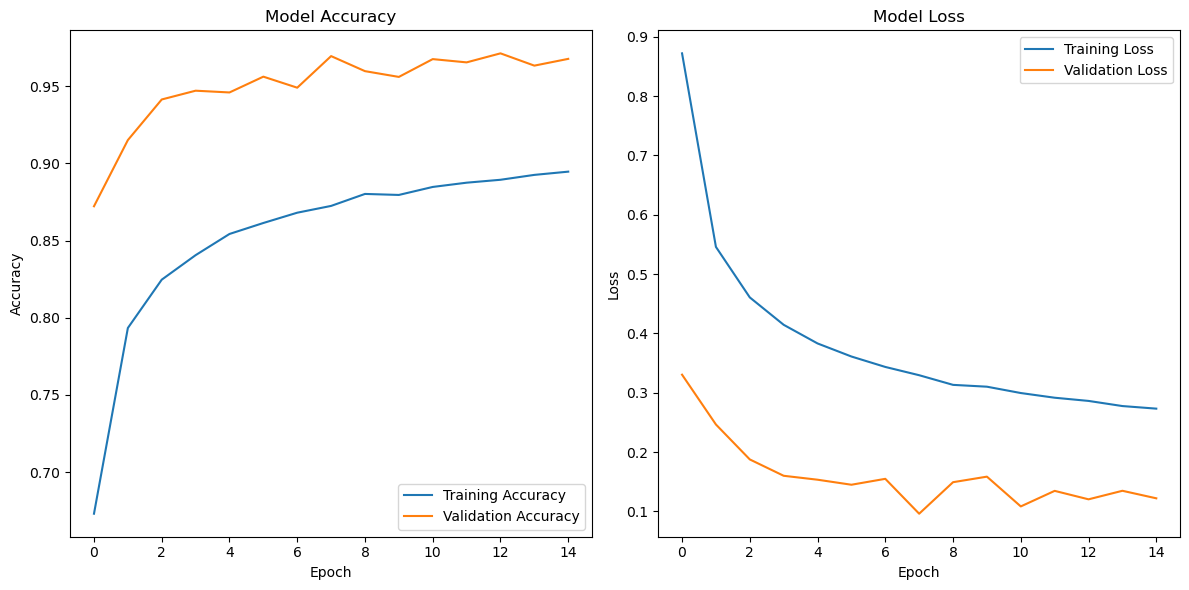

C:\Users\Public\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

model.save('fruit_classifier_model1.h5')


Found 6154 images belonging to 8 classes.
193/193 [==============================] - 98s 510ms/step
F1 Score: 0.9674


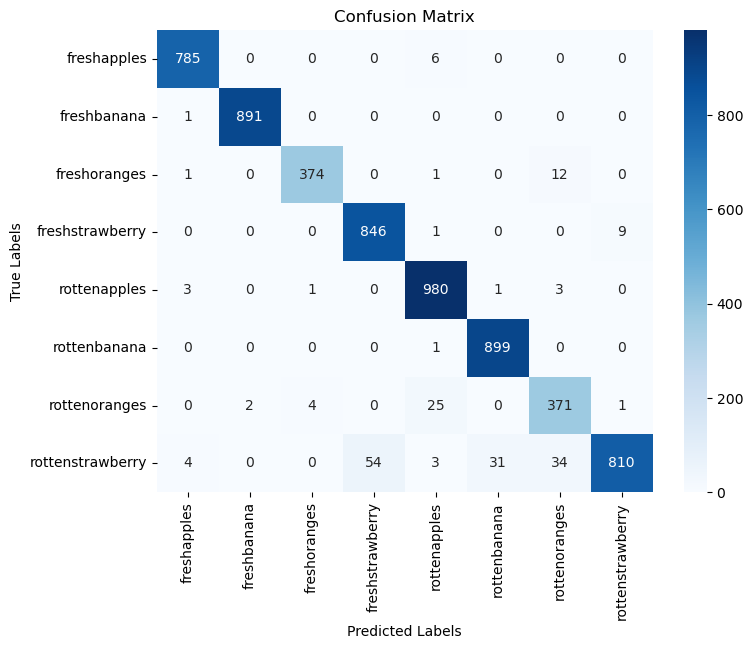

In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import cv2
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

from tensorflow.keras.models import load_model
# Load the pre-trained model
model_path = 'fruit_classifier_model.h5'
model = load_model(model_path)

# Set the path to your test dataset
test_data_dir = 'dataset/test_set'
img_width, img_height = 35, 35
batch_size = 32

# Data Preprocessing for testing set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Ensure labels are in the same order as predictions

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display F1 score
print(f"F1 Score: {f1:.4f}")

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Found 6154 images belonging to 8 classes.
193/193 [==============================] - 35s 181ms/step
F1 Score: 0.9674


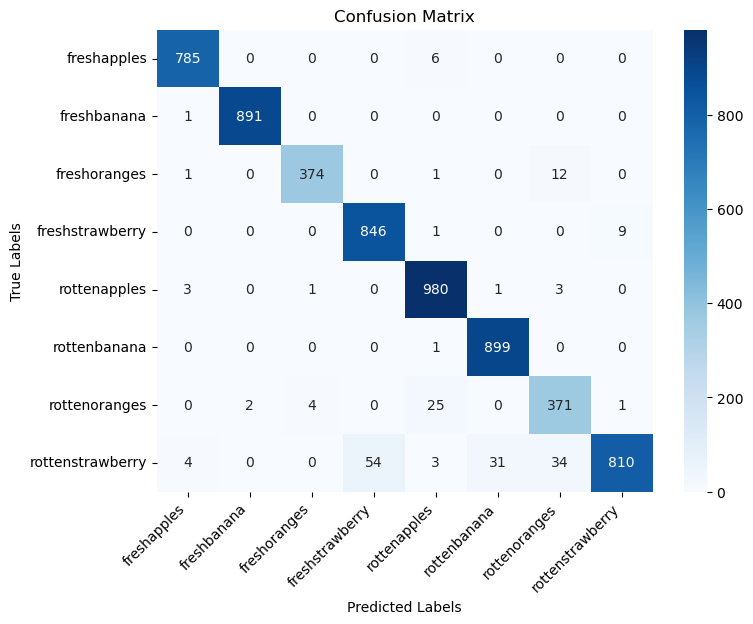

In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import cv2
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the pre-trained model
model_path = 'fruit_classifier_model.h5'
model = load_model(model_path)

# Set the path to your test dataset
test_data_dir = 'dataset/test_set'
img_width, img_height = 35, 35
batch_size = 32

# Data Preprocessing for testing set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Ensure labels are in the same order as predictions

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display F1 score
print(f"F1 Score: {f1:.4f}")

# Display Confusion Matrix with rotated x-axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices, cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.show()


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the pretrained model
model_path = 'fruit_classifier_model1.h5'
model = load_model(model_path)

# Function to predict the class of an image
def predict_image(image_path):
    img = load_img(image_path, target_size=(35, 35))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    classes = {0: 'fresh_apple', 1: 'fresh_banana', 2: 'fresh_orange', 3: 'fresh_strawberry', 4: 'rotten_apple', 5: 'rotten_banana', 6: 'rotten_orange', 7: 'rotten_strawberry'}

    # Normalize the probabilities to ensure the sum is 100%
    normalized_probabilities = predictions[0] / np.sum(predictions[0])

    # Print class probabilities
    for i in range(len(normalized_probabilities)):
        print(f"{classes[i]}: {normalized_probabilities[i] * 100:.7f} %")

    # Get the predicted class using the normalized probabilities
    predicted_class_index = np.argmax(normalized_probabilities)
    predicted_class = classes[predicted_class_index]

    print(f"Predicted class: {predicted_class}")

if __name__ == "__main__":
    # Example usage
    image_path = 'dataset/single_prediction/rotten_banana.jpg'
    predict_image(image_path)





1/1 [==============================] - 1s 596ms/step
fresh_apple: 0.0008257 %
fresh_banana: 0.0049473 %
fresh_orange: 0.0000000 %
fresh_strawberry: 0.0000000 %
rotten_apple: 0.0005130 %
rotten_banana: 99.9936938 %
rotten_orange: 0.0000180 %
rotten_strawberry: 0.0000016 %
Predicted class: rotten_banana
